# <font color='Violet'> <u> DEEP LEARNING ON USA DEMOCRATES DEBATE   </u></font>
## **By Pamela Dekas**


In [23]:
import sys
import csv
import re 
import nltk
import string
import unicodedata
from textblob import TextBlob
from collections import Counter
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.classify import * 
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk.classify.util
import matplotlib.pyplot as plt
from string import punctuation 
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import os
from sklearn.model_selection import train_test_split
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


AttributeError: module 'tensorflow.python.keras.backend' has no attribute 'get_graph'

In [24]:
speech = pd.read_csv('debate_transcripts_v3_2020-02-26.csv',encoding= 'unicode_escape')

In [25]:
df= pd.DataFrame(speech)
dem_speakers = df["speaker"]
number_of_speakers = len(set(dem_speakers))
print("Nombre de speakers:",number_of_speakers, "speakers")

# Mean duration of speech.
print("temps moyen de parole:",np.mean(df["speaking_time_seconds"]), "seconds")
print("Dataset size:", len(df))

Nombre de speakers: 106 speakers
temps moyen de parole: 16.49230769230769 seconds
Dataset size: 5911


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 6 columns):
date                     5911 non-null object
debate_name              5911 non-null object
debate_section           5911 non-null object
speaker                  5911 non-null object
speech                   5911 non-null object
speaking_time_seconds    5395 non-null float64
dtypes: float64(1), object(5)
memory usage: 277.2+ KB


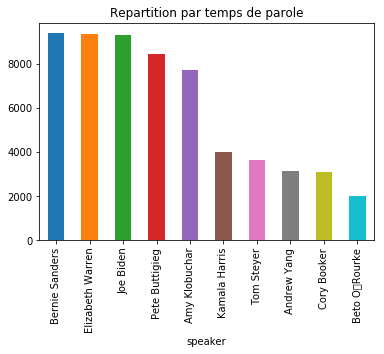

In [27]:
df.groupby('speaker')['speaking_time_seconds'].sum(level=0).nlargest(10).plot.bar()
plt.title('Repartition par temps de parole')
plt.show()

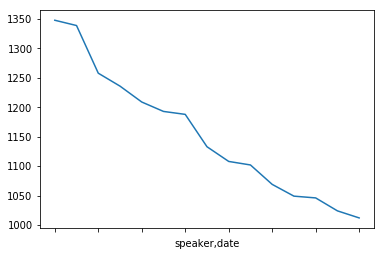

In [28]:
debate_time = df.groupby(by=['speaker', 'date']).speaking_time_seconds.sum().nlargest(15)
debate_time.plot()

### suppresion des colonnes qui ne seront pas utilisé dans la suite du projet et creation du dataset final###

In [29]:
df=df.drop(['date','debate_name','debate_section','speaking_time_seconds'],1)
df.head(5)

,speaker,speech
0,Norah ODonnell,"Good evening and welcome, the Democratic presi..."
1,Gayle King,And Super Tuesday is just a week away and this...
2,Norah ODonnell,And CBS News is proud to bring you this debate...
3,Gayle King,And we are partnering tonight also with Twitte...
4,Norah ODonnell,"Now, here are the rules for the next two hours..."


  <font color='Violet'> <u> PREPROCESSING  </u></font>

In [30]:
import nltk 
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
Tailored_stopwords=('im','ive','mr','weve','dont','well','will','make','us','we',
                      'I','make','got','need','want','think',
                      'going','go','one','thank','going',
                      'way','say','every','re','us','first',
                     'now','said','know','look','done','take',
                     'number','two','three','s','m',"t",
                      'let','don','tell','ve','im','mr','put','maybe','whether','many', 'll','around','thing','Secondly','doesn','lot')
#stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(STOPWORDS)
stopwords= stopwords.union(Tailored_stopwords)

[nltk_data] Downloading package punkt to C:\Users\pamel.DESKTOP-O19M7N
[nltk_data]     F\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
def Text_cleansing(speech):
    speech = re.sub('@[A-Za-z0–9]+', '', str(speech))
    speech = re.sub('#', '', speech) # Enlever les '#' hash tag
    speech = re.sub('rt', '', speech)
    speech=re.sub(',',' ', speech)
    speech=re.sub('!',' ',speech)
    speech=re.sub(':',' ',speech)
    speech=re.sub("'","",speech)
    speech=re.sub('"','',speech)
    speech=speech.lower()
    speech = word_tokenize(speech)
    return speech

In [32]:
def remove_stopwords(speech):
    speech_clean = [word for word in speech if word not in stopwords]
    return speech_clean
                         

In [33]:
df['speech_tokens']= df['speech'].apply(Text_cleansing)
df.head(5)

,speaker,speech,speech_tokens
0,Norah ODonnell,"Good evening and welcome, the Democratic presi...","[good, evening, and, welcome, the, democratic,..."
1,Gayle King,And Super Tuesday is just a week away and this...,"[and, super, tuesday, is, just, a, week, away,..."
2,Norah ODonnell,And CBS News is proud to bring you this debate...,"[and, cbs, news, is, proud, to, bring, you, th..."
3,Gayle King,And we are partnering tonight also with Twitte...,"[and, we, are, panering, tonight, also, with, ..."
4,Norah ODonnell,"Now, here are the rules for the next two hours...","[now, here, are, the, rules, for, the, next, t..."


In [34]:
df['speech_clean']=df['speech_tokens'].apply(remove_stopwords)
df.head(5)

,speaker,speech,speech_tokens,speech_clean
0,Norah ODonnell,"Good evening and welcome, the Democratic presi...","[good, evening, and, welcome, the, democratic,...","[good, evening, welcome, democratic, president..."
1,Gayle King,And Super Tuesday is just a week away and this...,"[and, super, tuesday, is, just, a, week, away,...","[super, tuesday, week, away, biggest, primary,..."
2,Norah ODonnell,And CBS News is proud to bring you this debate...,"[and, cbs, news, is, proud, to, bring, you, th...","[cbs, news, proud, bring, debate, along, co-sp..."
3,Gayle King,And we are partnering tonight also with Twitte...,"[and, we, are, panering, tonight, also, with, ...","[panering, tonight, twitter, ., home, paicipat..."
4,Norah ODonnell,"Now, here are the rules for the next two hours...","[now, here, are, the, rules, for, the, next, t...","[rules, next, hours, ., asked, question, minut..."


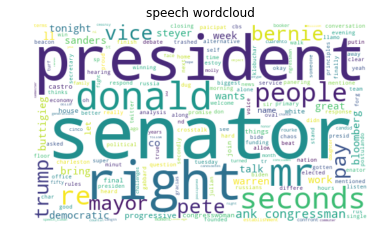

In [35]:
def wordcloud(dataframe):
    Aw= df['speech_clean']
    wordCloud = WordCloud(width=500, height=300,background_color='white', max_font_size=110).generate(str(Aw))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("speech wordcloud")

wordcloud(df['speech_clean'])

### Pour la suite du projet on reduira la liste des speakers aux candidats les plus notoires (top 7 speakers)###

In [36]:
df = df.loc[df.speaker.isin({'Joe Biden', 'Bernie Sanders', 'Elizabeth Warren', 'Michael Bloomberg', 'Pete Buttigieg', 'Amy Klobuchar',  'Tulsi Gabbard'})]
df.head()
df.shape

(2245, 4)

### CountVectorizer et creation du dict des mots par candidat a utiliser sur les modeles ML qui seront en back-up###

### Analyse Lexicale ###

In [37]:
cv = CountVectorizer(stop_words=stopwords)
df_cv = cv.fit_transform(df.speech)
df_words = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
df_words.index = df.speaker
df_words = df_words.transpose()
df_words

speaker,Bernie Sanders,Michael Bloomberg,Michael Bloomberg,Bernie Sanders,Pete Buttigieg,Elizabeth Warren,Elizabeth Warren,Pete Buttigieg,Joe Biden,Bernie Sanders,...,Amy Klobuchar,Elizabeth Warren,Amy Klobuchar,Tulsi Gabbard,Tulsi Gabbard,Amy Klobuchar,Amy Klobuchar,Amy Klobuchar,Elizabeth Warren,Elizabeth Warren
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001st,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
top_dict = {}
for c in df_words.columns:
    top = df_words[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
for speaker, top_words in top_dict.items():
    print(speaker)
    print(', '.join([word for word, count in top_words[0:9]]))
    print('---')

TypeError: sort_values() missing 1 required positional argument: 'by'

In [39]:
df2=pd.DataFrame(top_dict)
df2.head(15)

""


In [22]:
from collections import Counter
words = []
for speaker in df_words.columns:
    top = [word for (word, count) in top_dict[speaker]]
    for t in top:
        words.append(t)
Counter(words).most_common(15)

KeyError: 'Bernie Sanders'

### Implemantation du modèle###

In [16]:
print(df.columns)
print(df.shape)
df['speaker'] = df['speaker'].astype(str)

Index(['speaker', 'speech', 'speech_tokens', 'speech_clean'], dtype='object')
(2245, 4)


#### Embedding

In [20]:
import gensim

In [21]:
RANDOM_STATE = 50
EPOCHS = 5
BATCH_SIZE = 256
EMB_DIM = 100
SAVE_MODEL = True

X = df['speech_clean']
print(X.head())
X.shape

5     [well, youre, right, economy, really, great, ...
6                                            [senator-]
8     [think, donald, trump, thinks, would, better, ...
9     [oh, mr., bloomberg, ., let, tell, mr., putin,...
11     [know, president, russia, wants, its, chaos, .]
Name: speech_clean, dtype: object


(2245,)

In [22]:
emb_model = gensim.models.Word2Vec(sentences = X, size = EMB_DIM, window = 5, workers = 4, min_count = 1)

In [23]:
print('La taille du vocabulaire appris est de ',len(list(emb_model.wv.vocab)))

La taille du vocabulaire appris est de  7139


In [24]:
from keras.preprocessing.text import Tokenizer
import tokenize

In [25]:
max_length = max([len(s) for s in X])

tokenizer_new = Tokenizer()
tokenizer_new.fit_on_texts(X)

X_seq = tokenizer_new.texts_to_sequences(X)
X_fin = sequence.pad_sequences(X_seq, maxlen = max_length)
print(X_fin.shape)

(2245, 140)


In [26]:
emb_vec = emb_model.wv
MAX_NB_WORDS = len(list(emb_vec.vocab))
tokenizer_word_index = tokenizer_new.word_index
vocab_size = len(tokenizer_new.word_index) + 1

In [27]:
embedded_matrix = np.zeros((vocab_size, EMB_DIM))


for word, i in tokenizer_word_index.items():
    if i>= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = emb_vec[word]
        wv_matrix[i] = embedding_vector
    except:
        pass      

In [54]:
embedded_matrix.shape
print(embedded_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Préparation des variables


In [32]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [55]:
y = df.speaker
print(y.head(10))
y.shape

5     1
6     4
8     4
9     1
11    5
12    2
13    2
15    5
21    3
23    1
Name: speaker, dtype: int32


(2245,)

In [34]:
Counter(y)

Counter({'Bernie Sanders': 430,
         'Michael Bloomberg': 97,
         'Pete Buttigieg': 392,
         'Elizabeth Warren': 440,
         'Joe Biden': 456,
         'Amy Klobuchar': 353,
         'Tulsi Gabbard': 77})

In [35]:
le=LabelEncoder()
df['speaker'] = le.fit_transform(df['speaker'])
df.head()

y = df.speaker
y.head()
print(y.shape)
print(X_fin.shape)

(2245,)
(2245, 140)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_fin , y, test_size = 0.2, random_state = 42)


print(X_train.shape)
print(y_train.shape)

(1796, 140)
(1796,)


#### Construction des NN

In [68]:
model_pre_trained = Sequential()

model_pre_trained.add(Embedding(vocab_size, EMB_DIM, weights = [embedded_matrix], 
                    input_length = max_length, trainable = False))
model_pre_trained.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_pre_trained.add(Dense(1, activation='softmax'))

model_pre_trained.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_pre_trained.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 140, 100)          714000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 831,377
Trainable params: 117,377
Non-trainable params: 714,000
_________________________________________________________________


#### Fitting

In [69]:
history_pre_trained = model_pre_trained.fit(X_fin, y, batch_size = BATCH_SIZE, epochs =20, verbose =1, validation_split = 0.2)


Train on 1796 samples, validate on 449 samples
Epoch 1/20
1796/1796 [==============================] - 4s 2ms/step - loss: 0.5429 - accuracy: 0.1754 - val_loss: -0.4417 - val_accuracy: 0.2472
Epoch 2/20
1796/1796 [==============================] - 3s 2ms/step - loss: -6.7429 - accuracy: 0.1776 - val_loss: -14.1017 - val_accuracy: 0.2472
Epoch 3/20
1796/1796 [==============================] - 3s 2ms/step - loss: -15.8550 - accuracy: 0.1776 - val_loss: -19.5441 - val_accuracy: 0.2472
Epoch 4/20
1796/1796 [==============================] - 3s 2ms/step - loss: -20.7949 - accuracy: 0.1776 - val_loss: -23.4335 - val_accuracy: 0.2472
Epoch 5/20
1796/1796 [==============================] - 3s 2ms/step - loss: -24.1430 - accuracy: 0.1776 - val_loss: -25.9735 - val_accuracy: 0.2472
Epoch 6/20
1796/1796 [==============================] - 3s 2ms/step - loss: -26.4535 - accuracy: 0.1776 - val_loss: -28.0725 - val_accuracy: 0.2472
Epoch 7/20
1796/1796 [==============================] - 3s 2ms/step -

#### Evaluation du modèle

In [70]:
score = model_pre_trained.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: -51.148848297866785
Test accuracy: 0.18930958211421967


ptoblèmes: npmbre important de stopwords à rajouter au dictionnaire, doutes sur la fonction dactivation, stemming/lemmatization qui semble peu efficace; axes d'amélioration: explorer les N grammes pouir contextualiser les mots et creer u_n dictionnaire de stopwords customisé pour les deabts  ( association d'idées)/